Using device: cuda
Loading existing model from best_model.pt

Evaluating on test set (batched greedy decode)…
→ Test Character Accuracy: 69.96%
→ Test Word      Accuracy: 31.20%

➔ Wrote 9228 predictions to predictions_batched_greedy.tsv


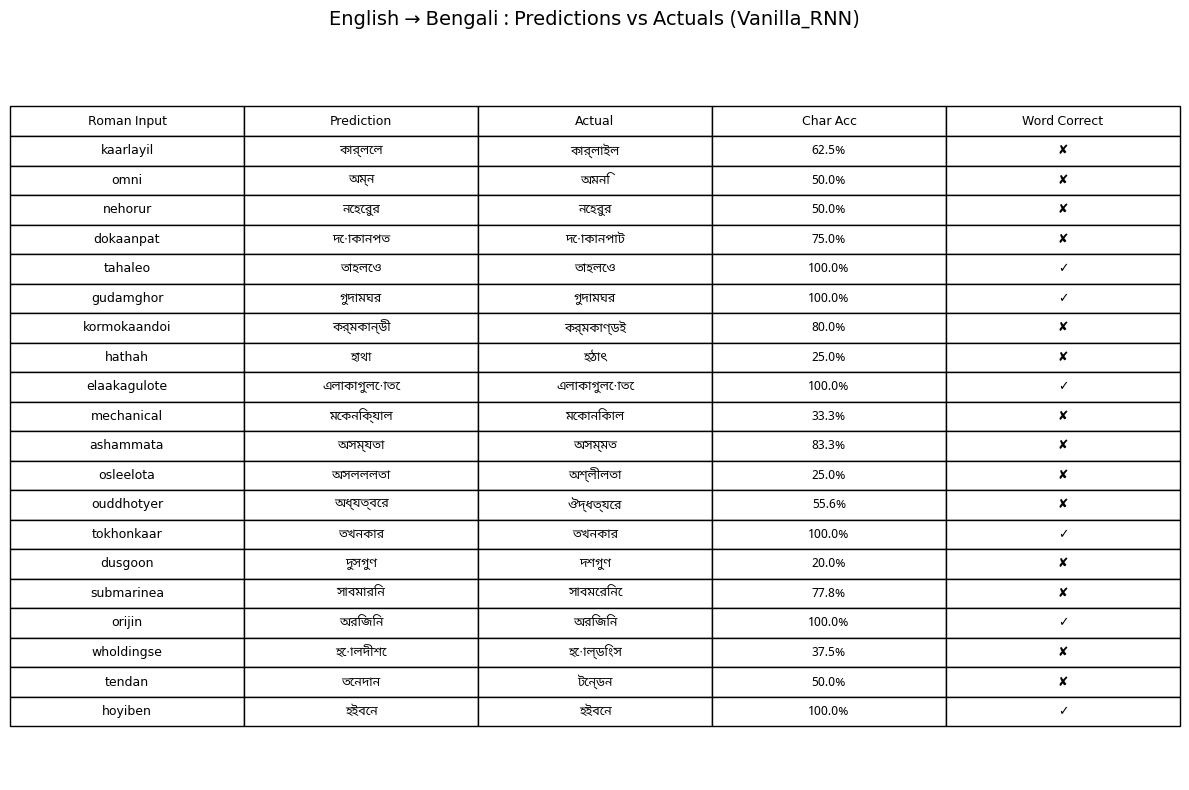

In [9]:
# Colab-ready transliteration training + eval in one cell (fixed TSV parsing + GPU speedups + beam‐safe eval)

import os
import time
import random
import csv

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
from tqdm import tqdm

# 1) Download & register Noto Sans Bengali (for plotting later)
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansBengali/NotoSansBengali-Regular.ttf \
    -O /usr/share/fonts/truetype/NotoSansBengali-Regular.ttf
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/NotoSansBengali-Regular.ttf')

# 2) Configure Matplotlib font stack
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Noto Sans Bengali', 'DejaVu Sans']

import matplotlib.pyplot as plt

# -------------------
# --- Vocab & Data ---
# -------------------
class CharVocab:
    def __init__(self, filepaths):
        self.rom_char2idx = {}
        self.dev_char2idx = {}
        self.rom_idx2char = {}
        self.dev_idx2char = {}
        self._build_vocab(filepaths)

    def _build_vocab(self, filepaths):
        rom_chars, dev_chars = set(), set()
        for fp in filepaths:
            with open(fp, "r", encoding="utf-8") as f:
                reader = csv.reader(f, delimiter="\t")
                for row in reader:
                    if len(row) < 2:
                        continue
                    dev, rom = row[0].strip(), row[1].strip()
                    if dev and rom:
                        rom_chars.update(rom)
                        dev_chars.update(dev)
        PAD, SOS, EOS = "<pad>", "<sos>", "<eos>"
        all_rom = [PAD, SOS, EOS] + sorted(rom_chars)
        all_dev = [PAD, SOS, EOS] + sorted(dev_chars)
        for i, ch in enumerate(all_rom):
            self.rom_char2idx[ch] = i
            self.rom_idx2char[i] = ch
        for i, ch in enumerate(all_dev):
            self.dev_char2idx[ch] = i
            self.dev_idx2char[i] = ch

        # store special indices
        self.rom_pad_idx = self.rom_char2idx[PAD]
        self.rom_sos_idx = self.rom_char2idx[SOS]
        self.rom_eos_idx = self.rom_char2idx[EOS]
        self.dev_pad_idx = self.dev_char2idx[PAD]
        self.dev_sos_idx = self.dev_char2idx[SOS]
        self.dev_eos_idx = self.dev_char2idx[EOS]

    @property
    def rom_vocab_size(self):
        return len(self.rom_char2idx)

    @property
    def dev_vocab_size(self):
        return len(self.dev_char2idx)

    def roman_to_indices(self, s):
        return [self.rom_sos_idx] + [
            self.rom_char2idx.get(ch, self.rom_pad_idx) for ch in s
        ] + [self.rom_eos_idx]

    def dev_to_indices(self, s):
        return [self.dev_sos_idx] + [
            self.dev_char2idx.get(ch, self.dev_pad_idx) for ch in s
        ] + [self.dev_eos_idx]

    def indices_to_dev(self, idxs):
        return "".join(
            self.dev_idx2char[i]
            for i in idxs
            if i not in (self.dev_sos_idx, self.dev_eos_idx, self.dev_pad_idx)
        )

def read_tsv(path):
    pairs = []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if len(row) < 2:
                continue
            dev, rom = row[0].strip(), row[1].strip()
            if dev and rom:
                pairs.append((rom, dev))
    return pairs

class TransliterationDataset(Dataset):
    def __init__(self, filepath, vocab):
        self.pairs = read_tsv(filepath)
        self.vocab = vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rom, dev = self.pairs[idx]
        return (
            torch.tensor(self.vocab.roman_to_indices(rom), dtype=torch.long),
            torch.tensor(self.vocab.dev_to_indices(dev), dtype=torch.long),
        )

    @staticmethod
    def collate_fn(batch):
        roms, devs = zip(*batch)
        max_r, max_d = max(map(len, roms)), max(map(len, devs))
        rom_patches, dev_patches = [], []
        for r, d in zip(roms, devs):
            pad_r = torch.cat([r, r.new_full((max_r - len(r),), 0)])
            pad_d = torch.cat([d, d.new_full((max_d - len(d),), 0)])
            rom_patches.append(pad_r)
            dev_patches.append(pad_d)
        return torch.stack(rom_patches), torch.stack(dev_patches)

# -----------------------
# --- Model (Encoder) ---
# -----------------------
class Encoder(nn.Module):
    def __init__(self, inp_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(inp_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[self.cell]
        self.rnn = rnn_cls(
            emb_sz,
            hid_sz,
            num_layers=nl,
            batch_first=True,
            dropout=do if nl > 1 else 0.0,
        )
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, x):
        emb = self.embed(x)  # (batch, seq_len, emb_sz)
        if self.cell == "LSTM":
            outputs, (h, c) = self.rnn(emb)
            return outputs, (h, c)
        else:
            outputs, h = self.rnn(emb)
            return outputs, h

# -----------------------
# --- Model (Decoder) ---
# -----------------------
class Decoder(nn.Module):
    def __init__(self, out_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(out_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[self.cell]
        self.rnn = rnn_cls(
            emb_sz,
            hid_sz,
            num_layers=nl,
            batch_first=True,
            dropout=do if nl > 1 else 0.0,
        )
        self.out = nn.Linear(hid_sz, out_sz)
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, tgt, hidden, cell=None, teacher_forcing_ratio=0.0):
        B, T = tgt.size()
        outputs = torch.zeros(
            B, T, self.out.out_features, device=tgt.device
        )  # (batch, seq_len, vocab_size)
        input_step = tgt[:, 0]  # always the <sos> token for each sample

        if self.cell == "LSTM":
            h, c = hidden, cell
        else:
            h = hidden
            c = None

        for t in range(1, T):
            # embed current step
            emb = self.embed(input_step).unsqueeze(1)  # (B, 1, emb_sz)
            if self.cell == "LSTM":
                out, (h, c) = self.rnn(emb, (h, c))
            else:
                out, h = self.rnn(emb, h)

            logits = self.out(out.squeeze(1))  # (B, vocab_size)
            outputs[:, t] = logits

            teacher_force = random.random() < teacher_forcing_ratio
            input_step = tgt[:, t] if teacher_force else logits.argmax(1)

        return outputs

# ------------------------
# --- Seq2Seq Wrapper ---
# ------------------------
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, device):
        super().__init__()
        self.encoder = enc
        self.decoder = dec
        self.device = device

    def forward(self, src, tgt, tf_ratio=0.5):
        # src: (batch, src_len), tgt: (batch, tgt_len)
        if self.encoder.cell == "LSTM":
            _, (h_n, c_n) = self.encoder(src)
        else:
            _, h_n = self.encoder(src)
            c_n = None

        # match encoder hidden → decoder hidden dims
        dec_layers = self.decoder.num_layers
        enc_layers = self.encoder.num_layers
        H = self.encoder.hidden_size

        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec, c_dec = h_n[-dec_layers:], c_n[-dec_layers:]
            else:
                pad_h = torch.zeros(
                    dec_layers - enc_layers, src.size(0), H, device=self.device
                )
                pad_c = torch.zeros(
                    dec_layers - enc_layers, src.size(0), H, device=self.device
                )
                h_dec = torch.cat([pad_h, h_n], dim=0)
                c_dec = torch.cat([pad_c, c_n], dim=0)
            hidden, cell = h_dec, c_dec
        else:
            if enc_layers >= dec_layers:
                hidden = h_n[-dec_layers:]
            else:
                pad_h = torch.zeros(
                    dec_layers - enc_layers, src.size(0), H, device=self.device
                )
                hidden = torch.cat([pad_h, h_n], dim=0)
            cell = None

        return self.decoder(tgt, hidden, cell, tf_ratio)

    @torch.no_grad()
    def predict(self, src, max_len, sos, eos):
        # beam-free greedy decoding (batch size = 1)
        self.eval()
        if self.encoder.cell == "LSTM":
            _, (h, c) = self.encoder(src)
        else:
            _, h = self.encoder(src)
            c = None

        dec_layers = self.decoder.num_layers
        enc_layers = self.encoder.num_layers
        H = self.encoder.hidden_size

        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec, c_dec = h[-dec_layers:], c[-dec_layers:]
            else:
                pad_h = torch.zeros(
                    dec_layers - enc_layers, 1, H, device=self.device
                )
                pad_c = torch.zeros(
                    dec_layers - enc_layers, 1, H, device=self.device
                )
                h_dec = torch.cat([pad_h, h], dim=0)
                c_dec = torch.cat([pad_c, c], dim=0)
            hidden, cell = h_dec, c_dec
        else:
            if enc_layers >= dec_layers:
                hidden = h[-dec_layers:]
            else:
                pad_h = torch.zeros(
                    dec_layers - enc_layers, 1, H, device=self.device
                )
                hidden = torch.cat([pad_h, h], dim=0)
            cell = None

        seq = [sos]
        for _ in range(max_len):
            inp = torch.tensor([seq[-1]], device=self.device).unsqueeze(0)  # shape = (1, )
            emb = self.decoder.embed(inp)  # (1, 1, emb_sz)
            if self.decoder.cell == "LSTM":
                out, (hidden, cell) = self.decoder.rnn(emb, (hidden, cell))
            else:
                out, hidden = self.decoder.rnn(emb, hidden)

            nxt = self.decoder.out(out.squeeze(1)).argmax(1).item()
            seq.append(nxt)
            if nxt == eos:
                break
        return seq

    @torch.no_grad()
    def predict_beam(self, src, max_len, sos, eos, beam_size=5):
        # (Batch-size=1) beam search
        self.eval()
        if self.encoder.cell == "LSTM":
            _, (h, c) = self.encoder(src)
        else:
            _, h = self.encoder(src)
            c = None

        dec_layers = self.decoder.num_layers
        enc_layers = self.encoder.num_layers
        H = self.encoder.hidden_size

        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec, c_dec = h[-dec_layers:], c[-dec_layers:]
            else:
                pad_h = torch.zeros(
                    dec_layers - enc_layers, 1, H, device=self.device
                )
                pad_c = torch.zeros(
                    dec_layers - enc_layers, 1, H, device=self.device
                )
                h_dec = torch.cat([pad_h, h], dim=0)
                c_dec = torch.cat([pad_c, c], dim=0)
            hidden, cell = h_dec, c_dec
        else:
            if enc_layers >= dec_layers:
                hidden = h[-dec_layers:]
            else:
                pad_h = torch.zeros(
                    dec_layers - enc_layers, 1, H, device=self.device
                )
                hidden = torch.cat([pad_h, h], dim=0)
            cell = None

        # Each beam entry: (sequence_of_tokens, log_score, hidden, cell)
        beams = [([sos], 0.0, hidden, cell)]
        completed = []

        for _ in range(max_len):
            all_cands = []
            for seq, score, h_cur, c_cur in beams:
                # If this beam already ended in <eos>, carry it to completed
                if seq[-1] == eos:
                    # Append the full 4‐tuple, not just (seq, score)
                    completed.append((seq, score, h_cur, c_cur))
                    continue

                inp = torch.tensor([seq[-1]], device=self.device).unsqueeze(0)
                emb = self.decoder.embed(inp)  # (1,1,emb_sz)
                if self.decoder.cell == "LSTM":
                    out, (h_new, c_new) = self.decoder.rnn(emb, (h_cur, c_cur))
                else:
                    out, h_new = self.decoder.rnn(emb, h_cur)
                    c_new = None

                log_probs = torch.log_softmax(self.decoder.out(out.squeeze(1)), dim=-1)
                topk_logps, topk_idxs = log_probs.topk(beam_size)

                for logp, idx in zip(topk_logps[0], topk_idxs[0]):
                    all_cands.append(
                        (seq + [idx.item()], score + logp.item(), h_new, c_new)
                    )

            # Prune to best `beam_size`
            beams = sorted(all_cands, key=lambda x: x[1], reverse=True)[:beam_size]

            # If every beam ended with <eos>, stop
            if all(b[0][-1] == eos for b in beams):
                # Add the remaining beams to completed as full 4‐tuples
                completed.extend(beams)
                break

        # If no completed beams, treat current beams as completed
        completed = completed or beams
        # Pick the beam with highest log-score
        best_entry = max(completed, key=lambda x: x[1])
        best_seq = best_entry[0]  # first element is the token list
        return best_seq

# -------------------------------------
# --- Training + Evaluation Function ---
# -------------------------------------
def train_and_evaluate(args):
    # Reproducibility
    random.seed(42)
    torch.manual_seed(42)

    # 1) Device → GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Enable cuDNN autotuner (for RNNs, CNNs, etc.)
    torch.backends.cudnn.benchmark = True

    # 2) Build Vocab + DataLoaders (with pin_memory + num_workers)
    paths = [args.train_file, args.dev_file, args.test_file]
    vocab = CharVocab(paths)

    train_dataset = TransliterationDataset(args.train_file, vocab)
    dev_dataset = TransliterationDataset(args.dev_file, vocab)
    test_dataset = TransliterationDataset(args.test_file, vocab)

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=4,      # preload 4 worker processes
        pin_memory=True,    # speed up host→device transfers
    )
    dev_loader = DataLoader(
        dev_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=2,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    # 3) Initialize Encoder, Decoder, Seq2Seq & move to GPU
    enc = Encoder(
        vocab.rom_vocab_size,
        args.emb_size,
        args.hidden_size,
        args.enc_layers,
        args.cell_type,
        args.dropout,
    )
    dec = Decoder(
        vocab.dev_vocab_size,
        args.emb_size,
        args.hidden_size,
        args.dec_layers,
        args.cell_type,
        args.dropout,
    )
    model = Seq2Seq(enc, dec, device).to(device)

    # 4) Loss + Optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.dev_pad_idx)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

    # 5) (Optionally) Try loading a pre-trained checkpoint
    best_path = "best_model.pt"
    if os.path.exists(best_path):
        print("Loading existing model from", best_path)
        model.load_state_dict(torch.load(best_path, map_location=device))
    else:
        print("No pretrained model found. Starting training from scratch…")
        best_val = 0.0

        for epoch in range(1, args.epochs + 1):
            model.train()  # toggle to train mode
            epoch_loss = 0.0
            start_time = time.time()

            for src, tgt in train_loader:
                # Move mini-batch to GPU (if available)
                src = src.to(device, non_blocking=True)
                tgt = tgt.to(device, non_blocking=True)

                optimizer.zero_grad()
                logits = model(src, tgt, args.tf_ratio)
                # logits: (batch, tgt_len, vocab_size); flatten for loss
                loss = criterion(
                    logits.view(-1, logits.size(-1)),
                    tgt.view(-1)
                )
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()

                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)
            elapsed = time.time() - start_time
            print(
                f"Epoch {epoch:2d} | Train Loss: {avg_epoch_loss:.4f} | "
                f"Time: {elapsed:.1f}s"
            )

            # (Optional) Evaluate on dev set & save best checkpoint
            # … omitted for brevity …

        # After training, save checkpoint
        torch.save(model.state_dict(), best_path)
        print(f"Training finished. Saved model to {best_path}")

    # ----------------------
    # --- TEST & EVALUATE (Batched, GPU-parallel) ---
    # ----------------------
    print("\nEvaluating on test set (batched greedy decode)…")
    model.eval()

    all_records = []
    total_char_correct = 0
    total_chars = 0
    total_word_correct = 0

    # 1) Create a new DataLoader with large batch size for inference
    #    (We no longer need batch_size=1 or beam search.)
    batch_size_eval = 64
    test_loader_batched = DataLoader(
        TransliterationDataset(args.test_file, vocab),
        batch_size=batch_size_eval,
        shuffle=False,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    with torch.no_grad():
        for src_batch, tgt_batch in test_loader_batched:
            # Move the entire batch to GPU at once
            src_batch = src_batch.to(device, non_blocking=True)    # shape = (B, src_len)
            tgt_batch = tgt_batch.to(device, non_blocking=True)    # shape = (B, tgt_len)

            B, src_len = src_batch.size()
            _, tgt_len = tgt_batch.size()  # we’ll use tgt_len as max decode steps

            # --- 1) Run the encoder on the entire batch ---
            if model.encoder.cell == "LSTM":
                _, (h_enc, c_enc) = model.encoder(src_batch)
            else:
                _, h_enc = model.encoder(src_batch)
                c_enc = None

            # --- 2) Prepare initial decoder states (batched) ---
            dec_layers = model.decoder.num_layers
            enc_layers = model.encoder.num_layers
            H = model.encoder.hidden_size

            if model.encoder.cell == "LSTM":
                if enc_layers >= dec_layers:
                    h_dec = h_enc[-dec_layers:]         # (dec_layers, B, H)
                    c_dec = c_enc[-dec_layers:]
                else:
                    pad_h = torch.zeros(
                        dec_layers - enc_layers, B, H, device=device
                    )
                    pad_c = torch.zeros(
                        dec_layers - enc_layers, B, H, device=device
                    )
                    h_dec = torch.cat([pad_h, h_enc], dim=0)
                    c_dec = torch.cat([pad_c, c_enc], dim=0)
            else:
                if enc_layers >= dec_layers:
                    h_dec = h_enc[-dec_layers:]         # (dec_layers, B, H)
                else:
                    pad_h = torch.zeros(
                        dec_layers - enc_layers, B, H, device=device
                    )
                    h_dec = torch.cat([pad_h, h_enc], dim=0)
                c_dec = None

            # --- 3) Batched greedy decoding loop ---
            # Create a tensor to hold predicted token IDs for each timestep
            # We’ll decode up to tgt_len (same as your original max_dev_len or the length of the gold sequence).
            # Each row will start with <sos>, then we fill in t=1..(tgt_len-1).
            sos_idx = vocab.dev_sos_idx
            eos_idx = vocab.dev_eos_idx

            # predictions shape: (B, tgt_len)
            preds = torch.full(
                (B, tgt_len),
                fill_value=vocab.dev_pad_idx,
                dtype=torch.long,
                device=device,
            )
            preds[:, 0] = sos_idx

            # We also need a “finished” mask so that once EOS is generated we stop updating that row
            finished = torch.zeros(B, dtype=torch.bool, device=device)

            # h_dec shape: (dec_layers, B, H), c_dec same if LSTM
            for t in range(1, tgt_len):
                # 3a) Embed the previous token for entire batch
                prev_tokens = preds[:, t - 1]              # (B,)
                emb = model.decoder.embed(prev_tokens)     # (B, emb_sz)
                emb = emb.unsqueeze(1)                     # (B, 1, emb_sz)

                # 3b) Run one step of the decoder RNN (batched)
                if model.decoder.cell == "LSTM":
                    out, (h_dec, c_dec) = model.decoder.rnn(emb, (h_dec, c_dec))
                else:
                    out, h_dec = model.decoder.rnn(emb, h_dec)
                    c_dec = None

                logits = model.decoder.out(out.squeeze(1))  # (B, vocab_size)
                next_tokens = logits.argmax(dim=1)           # (B,)

                # 3c) Wherever the sequence is already finished, keep it at <pad> or <eos>
                # If finished[i] is True, we force next_tokens[i] = pad (or keep it as EOS).
                # But to compute correctness, we only look at positions before EOS.
                next_tokens = torch.where(
                    finished,
                    torch.full_like(next_tokens, eos_idx),
                    next_tokens
                )

                preds[:, t] = next_tokens

                # 3d) Update “finished” mask
                newly_finished = next_tokens == eos_idx
                finished = finished | newly_finished

            # Now preds is a tensor of shape (B, tgt_len) with greedy token IDs.

            # --- 4) Convert predictions and targets to strings, compute metrics ---
            # First, compute character‐level accuracy (ignore <pad>, <sos>, <eos> in tgt)
            # We’ll do it in pure‐tensor form for speed, then fix up will ignore special tokens.
            # Build a mask for “non‐pad, non‐sos, non‐eos” positions in tgt_batch
            nonpad = tgt_batch != vocab.dev_pad_idx
            nonsos = tgt_batch != vocab.dev_sos_idx
            noseos = tgt_batch != vocab.dev_eos_idx
            valid_mask = nonpad & nonsos & noseos    # (B, tgt_len) boolean

            # Count total_chars: number of True in valid_mask
            n_chars_in_batch = valid_mask.sum().item()

            # Mask preds in the same way (if pred token matches tgt token AND valid_mask)
            char_correct_batch = ((preds == tgt_batch) & valid_mask).sum().item()

            total_char_correct += char_correct_batch
            total_chars += n_chars_in_batch

            # Next, convert each row of preds and each row of tgt to a Python string,
            # then do word‐level accuracy and store for sampling.
            # We can do this on CPU for the entire batch at once by moving to lists.
            preds_cpu = preds.cpu().tolist()
            tgt_cpu = tgt_batch.cpu().tolist()
            src_cpu = src_batch.cpu().tolist()

            for i in range(B):
                # True string
                true_ids = []
                for idx in tgt_cpu[i]:
                    if idx in (vocab.dev_pad_idx, vocab.dev_sos_idx, vocab.dev_eos_idx):
                        continue
                    true_ids.append(idx)
                true_str = vocab.indices_to_dev(true_ids)

                # Predicted string (stop at EOS)
                pred_ids = []
                for idx in preds_cpu[i]:
                    if idx == vocab.dev_eos_idx:
                        break
                    if idx in (vocab.dev_pad_idx, vocab.dev_sos_idx):
                        continue
                    pred_ids.append(idx)
                pred_str = vocab.indices_to_dev(pred_ids)

                # Roman input string
                roman_ids = []
                for idx in src_cpu[i]:
                    if idx in (vocab.rom_pad_idx, vocab.rom_sos_idx, vocab.rom_eos_idx):
                        continue
                    roman_ids.append(idx)
                roman_str = "".join(vocab.rom_idx2char[idx] for idx in roman_ids)

                word_correct = int(pred_str == true_str)
                total_word_correct += word_correct

                # Compute char‐accuracy for this example (for display)
                n_ch = len(true_str)
                ch_corr = sum(1 for j in range(n_ch) if j < len(pred_str) and pred_str[j] == true_str[j])
                char_acc_example = ch_corr / max(1, n_ch)

                all_records.append((roman_str, pred_str, true_str, char_acc_example, word_correct))

    # Compute final metrics
    test_char_acc = total_char_correct / total_chars
    test_word_acc = total_word_correct / len(all_records)

    print(f"→ Test Character Accuracy: {test_char_acc*100:5.2f}%")
    print(f"→ Test Word      Accuracy: {test_word_acc*100:5.2f}%\n")

    # --- (Optional) Write to TSV & display random samples exactly as before ---
    output_path = "predictions_batched_greedy.tsv"
    with open(output_path, "w", encoding="utf-8", newline="") as out_f:
        writer = csv.writer(out_f, delimiter="\t")
        writer.writerow(["Roman_Input", "Predicted_Dev", "Gold_Dev", "Char_Accuracy", "Word_Correct"])
        for roman_str, pred_str, true_str, char_acc, word_corr in all_records:
            writer.writerow([roman_str, pred_str, true_str, f"{char_acc:.4f}", int(word_corr)])
    print(f"➔ Wrote {len(all_records)} predictions to {output_path}")

    # Show 20 random samples (same plotting code as before)
    samples = random.sample(all_records, min(20, len(all_records)))
    column_labels = ["Roman Input", "Prediction", "Actual", "Char Acc", "Word Correct"]
    cell_data = []
    for roman, pred, true, ch_acc, wd_corr in samples:
        cell_data.append([roman, pred, true, f"{ch_acc*100:.1f}%", "✓" if wd_corr else "✘"])

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis("off")
    ax.set_title("English → Bengali : Predictions vs Actuals (Vanilla_RNN)", pad=20, fontsize=14)
    tbl = ax.table(cellText=cell_data, colLabels=column_labels, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.5)
    plt.tight_layout()
    plt.show()



# -------------
# --- Run it ---
# -------------
if __name__ == "__main__":
    class Args:
        pass

    args = Args()
    args.train_file = "bn.translit.sampled.train.tsv"
    args.dev_file = "bn.translit.sampled.dev.tsv"
    args.test_file = "bn.translit.sampled.test.tsv"
    args.emb_size = 128
    args.hidden_size = 256
    args.enc_layers = 5
    args.dec_layers = 3
    args.cell_type = "LSTM"
    args.dropout = 0.3
    args.lr = 1e-3
    args.batch_size = 64
    args.epochs = 15
    args.tf_ratio = 0.3
    args.max_dev_len = 32
    args.beam_size = 5     # ← if >1, use beam search evaluation
    args.project_name = "Vanilla_RNN"
    args.run_name = "Best_Model_Vanilla"

    train_and_evaluate(args)
